## Introduction

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

**How to Train [Detectron2](https://github.com/facebookresearch/detectron2) Segmentation on a Custom Dataset**

The notebook is based on official Detectron2 [colab notebook](https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5) and it covers:
- Python environment setup
- Inference using pre-trained models
- Download, register and visualize COCO Format Dataset
- Configure, train and evaluate model using custom COCO Format Dataset

**Preparing a Custom Dataset**

In this tutorial, we will utilize an open source computer vision dataset from one of the 100,000+ available on [Roboflow Universe](https://universe.roboflow.com).

If you already have your own images (and, optionally, annotations), you can convert your dataset using [Roboflow](https://roboflow.com), a set of tools developers use to build better computer vision models quickly and accurately. 150k+ developers use roboflow for (automatic) annotation, converting dataset formats (like to Detectron2), training, deploying, and improving their datasets/models.

Follow [the getting started guide here](https://docs.roboflow.com/quick-start) to create and prepare your own custom dataset. Make sure to select **Instance Segmentation** Option, If you want to create your own dataset on roboflow

Useful Dataset Links

* [Helmet Instace Segmentation ](https://universe.roboflow.com/computer-vision-hx9i9/helmet_polygon_v2/dataset/4)

* [PCB Board Instance Segmentation](https://universe.roboflow.com/chip/pcb_segmentation_yolov7/dataset/17)

* [Fire Segmentation Instance Segmentation](https://universe.roboflow.com/fire-instance-segmentation/fire-detection-pr6nj/dataset/1)

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator` and set it to `GPU`.

In [2]:
!nvcc --version
!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
Mon Dec 16 11:12:09 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.127.05             Driver Version: 550.127.05     CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-SXM2-16GB           On  |   00000000:00:1E.0 Off |                    0 |
| N/A   26C    P0       

In [23]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


## Install Detectron2 and dependencies

In [3]:
!pip install torch torchvision torchaudio
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Using cached torchaudio-2.5.1-cp311-cp311-manylinux1_x86_64.whl.metadata (6.4 kB)
  Using cached torch-2.5.1-cp311-cp311-manylinux1_x86_64.whl.metadata (28 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manyli

Now is a good time to confirm that we have the right versions of the libraries at our disposal.

In [4]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
torch:  2.5 ; cuda:  cu124
detectron2: 0.6


In [5]:
!pip install opencv-python opencv-python-headless

  Using cached opencv_python-4.10.0.84-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached opencv_python_headless-4.10.0.84-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
Using cached opencv_python-4.10.0.84-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (62.5 MB)
Using cached opencv_python_headless-4.10.0.84-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (49.9 MB)


In [6]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu125


Looking in indexes: https://download.pytorch.org/whl/cu125
Note: you may need to restart the kernel to use updated packages.


In [1]:
# COMMON LIBRARIES
import os
import cv2

from datetime import datetime


# DATA SET PREPARATION AND LOADING
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog

# VISUALIZATION
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode

# CONFIGURATION
from detectron2 import model_zoo
from detectron2.config import get_cfg

# EVALUATION
from detectron2.engine import DefaultPredictor

# TRAINING
from detectron2.engine import DefaultTrainer


## Run a Pre-trained Detectron2 Model

Before you start training, it's a good idea to check that everything is working properly. The best way to do this is to perform inference using a pre-trained model.

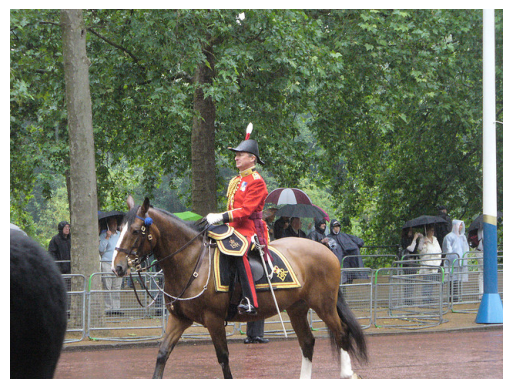

In [2]:
# Import necessary libraries
import cv2
import matplotlib.pyplot as plt

# Download the image
!wget http://images.cocodataset.org/val2017/000000439715.jpg -q -O input.jpg

# Read the image
image = cv2.imread("input.jpg")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for proper display

# Display the image using matplotlib
plt.imshow(image_rgb)
plt.axis("off")  # Hide axis labels
plt.show()

In [3]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(image)

/opt/conda/lib/python3.11/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [4]:
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([17,  0,  0,  0,  0,  0,  0,  0, 25,  0, 25, 25,  0,  0, 24],
       device='cuda:0')
Boxes(tensor([[126.6035, 244.8977, 459.8291, 480.0000],
        [251.1083, 157.8127, 338.9731, 413.6379],
        [114.8496, 268.6864, 148.2352, 398.8111],
        [  0.8217, 281.0327,  78.6072, 478.4210],
        [ 49.3954, 274.1229,  80.1545, 342.9808],
        [561.2248, 271.5816, 596.2755, 385.2552],
        [385.9072, 270.3125, 413.7130, 304.0397],
        [515.9295, 278.3744, 562.2792, 389.3802],
        [335.2409, 251.9167, 414.7491, 275.9375],
        [350.9300, 269.2060, 386.0984, 297.9081],
        [331.6292, 230.9996, 393.2759, 257.2009],
        [510.7349, 263.2656, 570.9865, 295.9194],
        [409.0841, 271.8646, 460.5582, 356.8722],
        [506.8767, 283.3257, 529.9403, 324.0392],
        [594.5663, 283.4820, 609.0577, 311.4124]], device='cuda:0'))


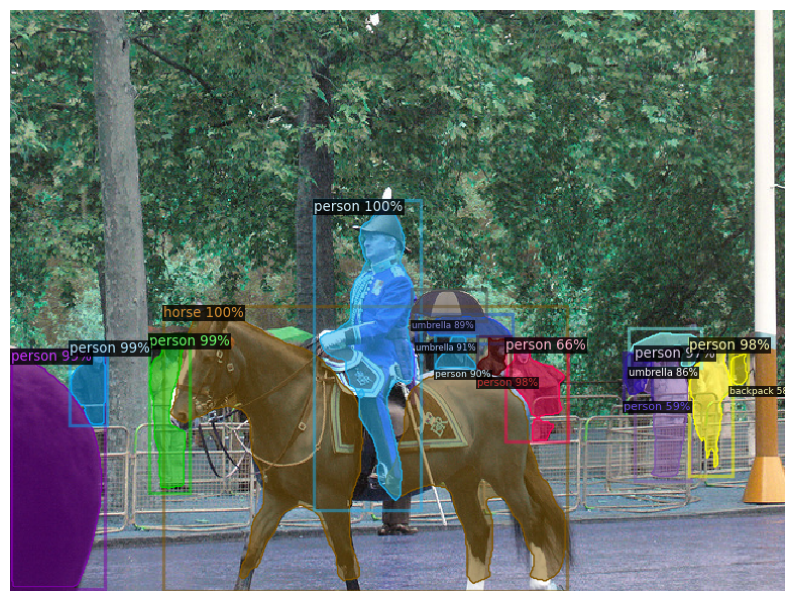

In [5]:
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer

# Visualize the predictions
visualizer = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))

# Convert to RGB and display using Matplotlib
output_image = out.get_image()[:, :, ::-1]  # Convert from BGR to RGB
plt.figure(figsize=(10, 10))
plt.imshow(output_image)
plt.axis("off")  # Hide axis labels
plt.show()


## COCO Format Dataset

### Download

We use `football-pitch-segmentation` dataset as example. Feel free to visit [Roboflow Universe](https://universe.roboflow.com/), and select any other Instance Segmentation dataset. Make sure to download the dataset in correct - `COCO Segmentation` format. 

Structure of your dataset should look like this:

```
dataset-directory/
├─ README.dataset.txt
├─ README.roboflow.txt
├─ train
│  ├─ train-image-1.jpg
│  ├─ train-image-1.jpg
│  ├─ ...
│  └─ _annotations.coco.json
├─ test
│  ├─ test-image-1.jpg
│  ├─ test-image-1.jpg
│  ├─ ...
│  └─ _annotations.coco.json
└─ valid
   ├─ valid-image-1.jpg
   ├─ valid-image-1.jpg
   ├─ ...
   └─ _annotations.coco.json
```

In [6]:
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances
import os

# Function to unregister the dataset
def unregister_dataset(dataset_name):
    """
    Unregisters the dataset from DatasetCatalog and MetadataCatalog.
    """
    if dataset_name in DatasetCatalog.list():
        DatasetCatalog.remove(dataset_name)
        MetadataCatalog.remove(dataset_name)
        print(f"Unregistered dataset: {dataset_name}")
    else:
        print(f"Dataset {dataset_name} not found in DatasetCatalog.")

# Function to modify and remove gt_masks
def remove_gt_masks_from_dataset(dataset_name):
    """
    Removes 'gt_masks' field from all instances in the registered dataset.
    """
    try:
        dataset_dicts = DatasetCatalog.get(dataset_name)  # Load dataset
        for entry in dataset_dicts:
            if "gt_masks" in entry:
                del entry["gt_masks"]
        print(f"Removed gt_masks from dataset: {dataset_name}")
    except KeyError:
        print(f"Dataset {dataset_name} not found or not properly registered.")

# Base dataset name
DATA_SET_NAME = "nursery_room_data"
ANNOTATIONS_FILE_NAME = "_annotations.coco.json"

# Dataset splits
splits = ["train", "val", "test"]

# Loop through splits to unregister, re-register, and remove 'gt_masks'
for split in splits:
    dataset_name = f"{DATA_SET_NAME}_{split}"
    annotations_path = os.path.join(DATA_SET_NAME, split, ANNOTATIONS_FILE_NAME)
    images_path = os.path.join(DATA_SET_NAME, split)
    
    # Unregister the dataset if already registered
    unregister_dataset(dataset_name)
    
    # Re-register the dataset
    register_coco_instances(dataset_name, {}, annotations_path, images_path)
    print(f"Registered dataset: {dataset_name}")
    
    # Remove 'gt_masks' after re-registration
    remove_gt_masks_from_dataset(dataset_name)

# Dynamically assign registered dataset names to variables
datasets = [
    data_set
    for data_set in MetadataCatalog.list()
    if data_set.startswith(DATA_SET_NAME)
]

# Ensure all dataset variables are assigned properly
TRAIN_DATA_SET_NAME = f"{DATA_SET_NAME}_train" if f"{DATA_SET_NAME}_train" in datasets else None
VAL_DATA_SET_NAME = f"{DATA_SET_NAME}_val" if f"{DATA_SET_NAME}_val" in datasets else None
TEST_DATA_SET_NAME = f"{DATA_SET_NAME}_test" if f"{DATA_SET_NAME}_test" in datasets else None

# Validate dataset variable assignment
if VAL_DATA_SET_NAME is None:
    raise ValueError(f"Validation dataset ({DATA_SET_NAME}_val) is not properly registered.")

# Print final results
print("Final Registered Datasets:", datasets)
print("Assigned Variables:")
print("Train Dataset Name:", TRAIN_DATA_SET_NAME)
print("Validation Dataset Name:", VAL_DATA_SET_NAME)
print("Test Dataset Name:", TEST_DATA_SET_NAME)



Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



Dataset nursery_room_data_train not found in DatasetCatalog.
Registered dataset: nursery_room_data_train
Removed gt_masks from dataset: nursery_room_data_train
Dataset nursery_room_data_val not found in DatasetCatalog.
Registered dataset: nursery_room_data_val
Removed gt_masks from dataset: nursery_room_data_val
Dataset nursery_room_data_test not found in DatasetCatalog.
Registered dataset: nursery_room_data_test
Removed gt_masks from dataset: nursery_room_data_test
Final Registered Datasets: ['nursery_room_data_train', 'nursery_room_data_val', 'nursery_room_data_test']
Assigned Variables:
Train Dataset Name: nursery_room_data_train
Validation Dataset Name: nursery_room_data_val
Test Dataset Name: nursery_room_data_test


### Register

When you use Detectron2, before you actually train the model you need to [register it](https://detectron2.readthedocs.io/en/latest/tutorials/datasets.html#register-a-coco-format-dataset).

In [7]:
[
    data_set
    for data_set
    in MetadataCatalog.list()
    if data_set.startswith(DATA_SET_NAME)
]

['nursery_room_data_train', 'nursery_room_data_val', 'nursery_room_data_test']

### Visualize

Let's take a look at single entry from out train dataset.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



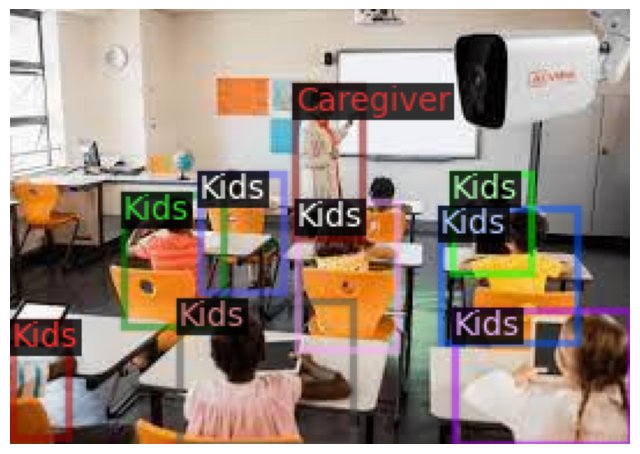

In [8]:
import matplotlib.pyplot as plt
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.utils.visualizer import Visualizer, ColorMode
import cv2

# Fetch metadata and dataset
metadata = MetadataCatalog.get(TRAIN_DATA_SET_NAME)
dataset_train = DatasetCatalog.get(TRAIN_DATA_SET_NAME)

# Access a sample entry
dataset_entry = dataset_train[0]

# Read the image
image = cv2.imread(dataset_entry["file_name"])

# Create a visualizer object
visualizer = Visualizer(
    image[:, :, ::-1], 
    metadata=metadata, 
    scale=1.0, 
    instance_mode=ColorMode.IMAGE
)
# Draw annotations on the image
out = visualizer.draw_dataset_dict(dataset_entry)

# Display the image using Matplotlib
plt.figure(figsize=(8, 8))  # Set figure size
plt.imshow(out.get_image())  # Matplotlib expects RGB images
plt.axis('off')  # Turn off axis for cleaner visualization
plt.show()


## Train Model Using Custom COCO Format Dataset 

### Configuration

In [48]:
# HYPERPARAMETERS
import os
ARCHITECTURE = "mask_rcnn_R_101_FPN_3x"
CONFIG_FILE_PATH = f"COCO-InstanceSegmentation/{ARCHITECTURE}.yaml"
MAX_ITER = 2000
EVAL_PERIOD = 200
BASE_LR = 0.001
NUM_CLASSES = 5

# OUTPUT DIR
OUTPUT_DIR_PATH = os.path.join(
    DATA_SET_NAME, 
    ARCHITECTURE, 
    datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
)

os.makedirs(OUTPUT_DIR_PATH, exist_ok=True)

In [49]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(CONFIG_FILE_PATH))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(CONFIG_FILE_PATH)
cfg.DATASETS.TRAIN = (TRAIN_DATA_SET_NAME,)
cfg.DATASETS.TEST = (TEST_DATA_SET_NAME,)
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.TEST.EVAL_PERIOD = EVAL_PERIOD
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = BASE_LR
cfg.SOLVER.MAX_ITER = MAX_ITER
cfg.MODEL.ROI_HEADS.NUM_CLASSES = NUM_CLASSES
cfg.OUTPUT_DIR = OUTPUT_DIR_PATH
cfg.MODEL.MASK_ON = False 
with open(os.path.join(cfg.OUTPUT_DIR, "config.yaml"), "w") as f:
    f.write(cfg.dump())

### Training

In [ ]:
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()


[12/16 11:54:04 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (6, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (6,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (20, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (20,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, 

[12/16 11:54:04 d2.engine.train_loop]: Starting training from iteration 0
[12/16 11:54:09 d2.utils.events]:  eta: 0:07:24  iter: 19  total_loss: 2.967  loss_cls: 1.946  loss_box_reg: 0.8218  loss_rpn_cls: 0.09863  loss_rpn_loc: 0.07707    time: 0.2126  last_time: 0.2248  data_time: 0.0133  last_data_time: 0.0011   lr: 1.9981e-05  max_mem: 3870M
[12/16 11:54:13 d2.utils.events]:  eta: 0:06:51  iter: 39  total_loss: 2.786  loss_cls: 1.694  loss_box_reg: 0.8494  loss_rpn_cls: 0.1226  loss_rpn_loc: 0.07485    time: 0.2091  last_time: 0.2198  data_time: 0.0053  last_data_time: 0.0041   lr: 3.9961e-05  max_mem: 3870M
[12/16 11:54:17 d2.utils.events]:  eta: 0:06:45  iter: 59  total_loss: 2.33  loss_cls: 1.262  loss_box_reg: 0.848  loss_rpn_cls: 0.1035  loss_rpn_loc: 0.07318    time: 0.2060  last_time: 0.1798  data_time: 0.0059  last_data_time: 0.0044   lr: 5.9941e-05  max_mem: 3870M
[12/16 11:54:21 d2.utils.events]:  eta: 0:06:49  iter: 79  total_loss: 1.939  loss_cls: 0.8836  loss_box_reg: 0

In [54]:
from detectron2.evaluation import COCOEvaluator
# After training, evaluate the model
# Create a COCO evaluator
evaluator = COCOEvaluator(TEST_DATA_SET_NAME, cfg, False, output_dir=OUTPUT_DIR_PATH)

# Perform evaluation using the evaluator (pass the model)
trainer.test(cfg, evaluators=[evaluator], model=trainer.model)


WARNING [12/16 12:01:27 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [12/16 12:01:27 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/16 12:01:27 d2.data.datasets.coco]: Loaded 25 images in COCO format from nursery_room_data/test/_annotations.coco.json
[12/16 12:01:27 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/16 12:01:27 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[12/16 12:01:27 d2.data.common]: Serializing 25 elements to byte tensors and concatenating them all ...
[12/16 12:01:27 d2.data.common]: Serialized dataset takes 0.02 MiB
[12/16 12:01:27 d2.evaluation.evaluator]: Start inference on 25 batches
[12/16 12:01:28 d2.evaluation

OrderedDict([('bbox',
              {'AP': 26.002764639601267,
               'AP50': 58.647435187646266,
               'AP75': 21.094497333637783,
               'APs': 12.446047376796052,
               'APm': 29.68582548891528,
               'APl': 29.188042587589287,
               'AP-Kids': 32.16003786137416,
               'AP-Caregiver': 39.93964759719669,
               'AP-Food': 11.128312010257265,
               'AP-Toys': 20.783061089576947})])

In [55]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir $OUTPUT_DIR_PATH

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6007 (pid 2837), started 0:00:13 ago. (Use '!kill 2837' to kill it.)

### Evaluation

In [56]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
predictor = DefaultPredictor(cfg)

[12/16 12:01:33 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from nursery_room_data/mask_rcnn_R_101_FPN_3x/2024-12-16-11-54-01/model_final.pth ...


/opt/conda/lib/python3.11/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

WARNING [12/16 12:01:33 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/16 12:01:33 d2.data.datasets.coco]: Loaded 19 images in COCO format from nursery_room_data/val/_annotations.coco.json
Randomly selected image: nursery_room_data/val/food_54_jpg.rf.b8f607bd16ab4d7a960a27a84909c46f.jpg


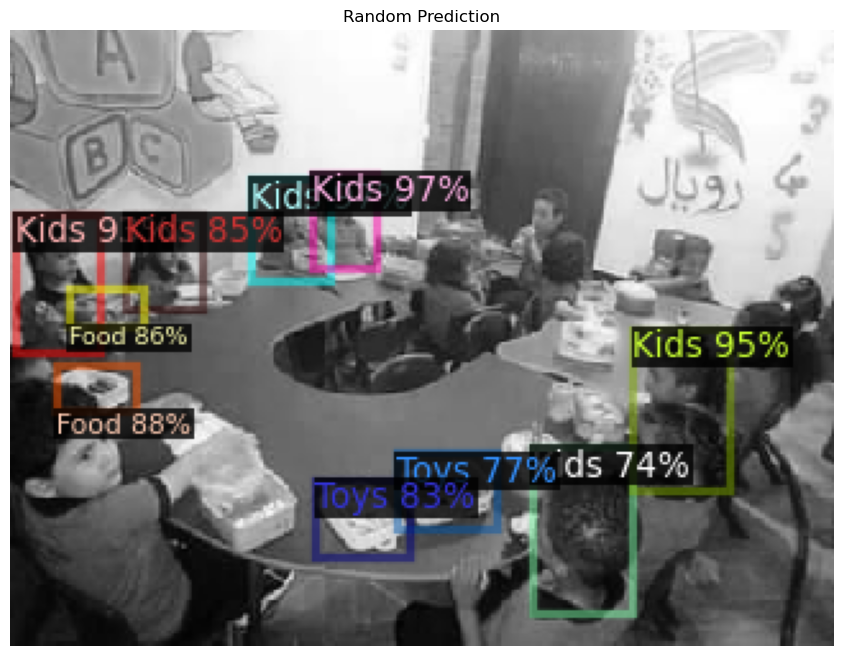

In [57]:
import cv2
import random
from detectron2.utils.visualizer import Visualizer, ColorMode
import matplotlib.pyplot as plt
from detectron2.data import DatasetCatalog
# Get the validation dataset

dataset_valid = DatasetCatalog.get("nursery_room_data_val")
metadata = MetadataCatalog.get(VAL_DATA_SET_NAME)
# Pick a random entry from the dataset
random_entry = random.choice(dataset_valid)
print(f"Randomly selected image: {random_entry['file_name']}")

# Load the image random
img = cv2.imread(random_entry["file_name"])

# Run the predictor on the image
outputs = predictor(img)

# Visualize the predictions
visualizer = Visualizer(
    img[:, :, ::-1],
    metadata=metadata, 
    scale=0.8, 
    instance_mode=ColorMode.IMAGE_BW
)
out = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))

# Convert the result to a format suitable for matplotlib
result_image = out.get_image()[:, :, ::-1]

# Display the result inline using matplotlib
plt.figure(figsize=(12, 8))
plt.imshow(result_image)
plt.axis("off")
plt.title("Random Prediction")
plt.show()


WARNING [12/16 12:01:34 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/16 12:01:34 d2.data.datasets.coco]: Loaded 19 images in COCO format from nursery_room_data/val/_annotations.coco.json


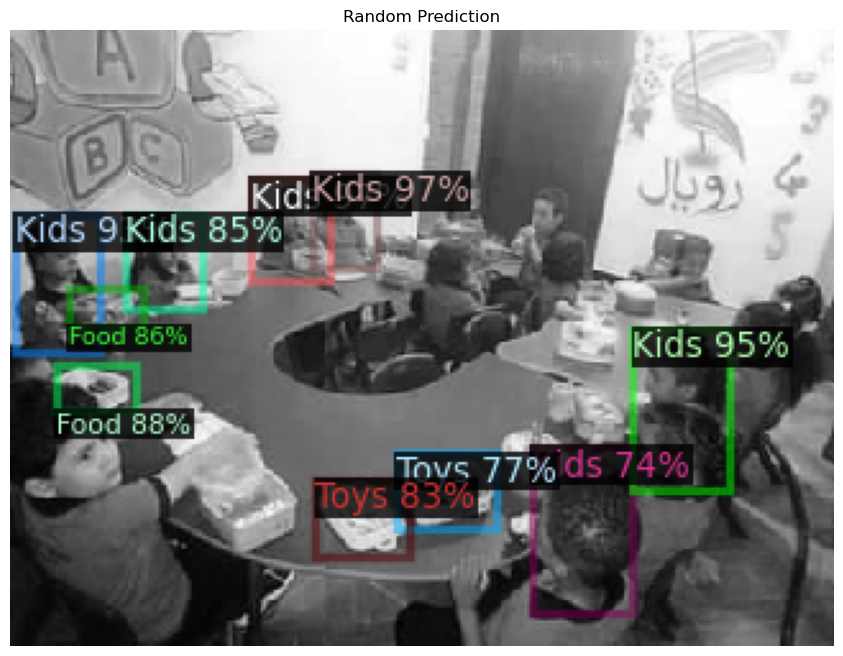

In [58]:
import cv2
import random
from detectron2.utils.visualizer import Visualizer, ColorMode
import matplotlib.pyplot as plt
from detectron2.data import DatasetCatalog
# Get the validation dataset
#file_name = "daycare.jpg"
dataset_valid = DatasetCatalog.get("nursery_room_data_val")
metadata = MetadataCatalog.get(VAL_DATA_SET_NAME)
# Pick a random entry from the dataset
#random_entry = random.choice(dataset_valid)
# print(f"Randomly selected image: {random_entry['file_name']}")

# Load the image random
img = cv2.imread(random_entry["file_name"])

# Run the predictor on the image
outputs = predictor(img)

# Visualize the predictions
visualizer = Visualizer(
    img[:, :, ::-1],
    metadata=metadata, 
    scale=0.8, 
    instance_mode=ColorMode.IMAGE_BW
)
out = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))

# Convert the result to a format suitable for matplotlib
result_image = out.get_image()[:, :, ::-1]

# Display the result inline using matplotlib
plt.figure(figsize=(12, 8))
plt.imshow(result_image)
plt.axis("off")
plt.title("Random Prediction")
plt.show()


**Collecting Output Inference**

In [59]:
instances = outputs["instances"]
detected_class_indexes = instances.pred_classes
prediction_boxes = instances.pred_boxes

metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])
class_catalog = metadata.thing_classes

# Create an empty list for class names
class_name_list=[]
for idx, coordinates in enumerate(prediction_boxes):
    class_index = detected_class_indexes[idx]
    class_name = class_catalog[class_index]
    class_name_list.append(class_name)
print(class_name_list)

['Kids', 'Kids', 'Kids', 'Kids', 'Food', 'Food', 'Kids', 'Toys', 'Toys', 'Kids']


**PREDICTING ALL IMAGES IN A TRAINING SET**

In [60]:
import cv2
import random
from detectron2.utils.visualizer import Visualizer, ColorMode
import matplotlib.pyplot as plt
from detectron2.data import DatasetCatalog, MetadataCatalog

# Initialize the list to store detected objects for each image
detected_objects_per_image = []

# Get the training dataset
dataset_train = DatasetCatalog.get(cfg.DATASETS.TRAIN[0])
metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])

# Define the target size for resizing (adjust the dimensions as needed)
target_width = 640  
target_height = 480  

# Iterate over all images in the dataset
for idx, entry in enumerate(dataset_train):
    # Load the image
    img = cv2.imread(entry["file_name"])

    # Resize the image
    img_resized = cv2.resize(img, (target_width, target_height))  # Resize to the target dimensions
    print(f"Image {entry['file_name']} resized to {img_resized.shape[1]}x{img_resized.shape[0]}")

    # Run the predictor on the resized image
    outputs = predictor(img_resized)

    # Get the detected class names from the outputs
    instances = outputs["instances"]
    detected_class_indexes = instances.pred_classes
    prediction_boxes = instances.pred_boxes

    # Get the class names from the metadata
    class_catalog = metadata.thing_classes

    # Create a list for the detected class names
    class_name_list = []
    for idx, coordinates in enumerate(prediction_boxes):
        class_index = detected_class_indexes[idx]
        class_name = class_catalog[class_index]
        class_name_list.append(class_name)

    # Append the results to the list
    detected_objects_per_image.append({
        'image': entry["file_name"],  # Use the file name as the image identifier
        'detected_objects': class_name_list  # Detected objects
    })

# Print the results
print("\nDetected objects in all images:")
for result in detected_objects_per_image:
    print(result)


WARNING [12/16 12:01:34 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/16 12:01:34 d2.data.datasets.coco]: Loaded 174 images in COCO format from nursery_room_data/train/_annotations.coco.json
Image nursery_room_data/train/caregiver40_jpeg_jpg.rf.00cce2b389bf52aed091c7bd080bb1ed.jpg resized to 640x480
Image nursery_room_data/train/G6867__435__7-16__7-20__fix_anonymized__frame-6_png_jpg.rf.047b27f7df0a73c9f3b3750ab6b9f64b.jpg resized to 640x480
Image nursery_room_data/train/caregiver18_png_jpg.rf.0120aefae7937baa49440687fbbf33d1.jpg resized to 640x480
Image nursery_room_data/train/nursery_134_jpeg_jpg.rf.06e4183d3c486a04e4271005330426be.jpg resized to 640x480
Image nursery_room_data/train/kids_162_jpg.rf.07ce79583461e6db8257852c2e23c256.jpg resized to 640x480
Image nursery_room_data/train/G8988__267__0-20__0-42__fix_anonymized__frame-98_png_jpg.rf.0958841affacaea5e39f03405b15b965.jpg resized to 640x480
Image nursery_r

In [61]:
# At this point, 'detected_objects_per_image' will contain the detected objects for each image
# You can now print the entire list or process it further
print("\nDetected objects in all images:")
for result in detected_objects_per_image:
    print(result)


Detected objects in all images:
{'image': 'nursery_room_data/train/caregiver40_jpeg_jpg.rf.00cce2b389bf52aed091c7bd080bb1ed.jpg', 'detected_objects': ['Kids', 'Kids', 'Kids', 'Kids', 'Kids', 'Caregiver', 'Kids', 'Kids', 'Kids']}
{'image': 'nursery_room_data/train/G6867__435__7-16__7-20__fix_anonymized__frame-6_png_jpg.rf.047b27f7df0a73c9f3b3750ab6b9f64b.jpg', 'detected_objects': ['Kids', 'Kids', 'Kids', 'Caregiver', 'Kids', 'Kids', 'Caregiver', 'Kids', 'Kids', 'Kids', 'Toys', 'Toys']}
{'image': 'nursery_room_data/train/caregiver18_png_jpg.rf.0120aefae7937baa49440687fbbf33d1.jpg', 'detected_objects': ['Kids', 'Kids', 'Food', 'Kids', 'Kids', 'Kids', 'Food', 'Kids', 'Kids', 'Kids', 'Food', 'Food', 'Kids', 'Caregiver', 'Kids']}
{'image': 'nursery_room_data/train/nursery_134_jpeg_jpg.rf.06e4183d3c486a04e4271005330426be.jpg', 'detected_objects': ['Toys', 'Toys', 'Toys', 'Toys', 'Toys', 'Toys', 'Toys', 'Toys']}
{'image': 'nursery_room_data/train/kids_162_jpg.rf.07ce79583461e6db8257852c2e23c2

In [62]:
# Print the results
print("\nDetected objects in all images:")
for result in detected_objects_per_image:
    print(result)


Detected objects in all images:
{'image': 'nursery_room_data/train/caregiver40_jpeg_jpg.rf.00cce2b389bf52aed091c7bd080bb1ed.jpg', 'detected_objects': ['Kids', 'Kids', 'Kids', 'Kids', 'Kids', 'Caregiver', 'Kids', 'Kids', 'Kids']}
{'image': 'nursery_room_data/train/G6867__435__7-16__7-20__fix_anonymized__frame-6_png_jpg.rf.047b27f7df0a73c9f3b3750ab6b9f64b.jpg', 'detected_objects': ['Kids', 'Kids', 'Kids', 'Caregiver', 'Kids', 'Kids', 'Caregiver', 'Kids', 'Kids', 'Kids', 'Toys', 'Toys']}
{'image': 'nursery_room_data/train/caregiver18_png_jpg.rf.0120aefae7937baa49440687fbbf33d1.jpg', 'detected_objects': ['Kids', 'Kids', 'Food', 'Kids', 'Kids', 'Kids', 'Food', 'Kids', 'Kids', 'Kids', 'Food', 'Food', 'Kids', 'Caregiver', 'Kids']}
{'image': 'nursery_room_data/train/nursery_134_jpeg_jpg.rf.06e4183d3c486a04e4271005330426be.jpg', 'detected_objects': ['Toys', 'Toys', 'Toys', 'Toys', 'Toys', 'Toys', 'Toys', 'Toys']}
{'image': 'nursery_room_data/train/kids_162_jpg.rf.07ce79583461e6db8257852c2e23c2

In [63]:
print(f"Number of images processed: {len(detected_objects_per_image)}")

Number of images processed: 174


**Process the predicted class and store the output in a file**

In [64]:
import pandas as pd
import numpy as np
import ast

# Initialize the results list to store the output for each image
results = []

# Normalize object_limits to lowercase
object_limits = {
    "kid": 15,
    "toy": 20,
    "food": 5,
    "caregiver": 5
}

# Normalization map to handle plural forms (now it's case insensitive)
normalization_map = {
    "kids": "kid",  # map plural 'kids' to 'kid'
    "toys": "toy",  # map plural 'toys' to 'toy'
    "caregiver": "caregiver",  # map plural 'caregivers' to 'caregiver'
    "food": "food",  # food is singular, no need for plural handling
}

# Function to apply quantifiers and compute facet scores
def apply_quantifiers_and_compute_facet_scores(class_name_list):
    detected_objects = {name: 0 for name in object_limits.keys()}

    # Count occurrences of each object (including plural handling)
    for class_name in class_name_list:
        normalized_name = class_name.strip().lower()  # Normalize to lowercase
        normalized_name = normalization_map.get(normalized_name, normalized_name)  # Handle plural forms
        
        if normalized_name in detected_objects:
            detected_objects[normalized_name] += 1

    print(f"\nDetected objects after counting: {detected_objects}")  # Print detected objects count before quantifier

    # Apply quantifier limits
    for obj_name, count in detected_objects.items():
        if count > object_limits[obj_name]:  # Compare with normalized object_limits
            print(f"Excluding image: Too many {obj_name}s detected (exceeds limit).")
            return None  # Drop the image
    
    facet_scores = compute_facet_scores(detected_objects)
    
    # Calculate Aavg (Average Aggregate Score) for the image
    total_facet_scores = 0
    total_objects = 0
    for obj_name, scores in facet_scores.items():
        facet_average = np.mean(list(scores.values()))  # Average facet score for each object
        total_facet_scores += facet_average * detected_objects[obj_name]  # Multiply by object count
        total_objects += detected_objects[obj_name]

    Aavg = total_facet_scores / total_objects if total_objects > 0 else 0
    return detected_objects, facet_scores, Aavg

# Function to compute facet scores for objects
def compute_facet_scores(detected_objects):
    facet_scores = {}
    for obj, count in detected_objects.items():
        normalized_name = obj.lower()
        normalized_name = normalization_map.get(normalized_name, normalized_name)

        # Assign reasonable facet scores based on object type
        if normalized_name == "kid":
            facet_scores[normalized_name] = {
                "plausibility": 0.9,
                "typicality": 0.95,
                "remarkability": 0.95,
                "salience": 0.85
            }
        elif normalized_name == "toy":
            facet_scores[normalized_name] = {
                "plausibility": 0.85,
                "typicality": 0.9,
                "remarkability": 0.7,
                "salience": 0.8
            }
        elif normalized_name == "food":
            facet_scores[normalized_name] = {
                "plausibility": 0.6,
                "typicality": 0.5,
                "remarkability": 0.6,
                "salience": 0.65
            }
        elif normalized_name == "caregiver":
            facet_scores[normalized_name] = {
                "plausibility": 0.75,
                "typicality": 0.8,
                "remarkability": 0.85,
                "salience": 0.75
            }
        else:
            facet_scores[normalized_name] = {
                "plausibility": 0.5,
                "typicality": 0.5,
                "remarkability": 0.5,
                "salience": 0.5
            }

    return facet_scores

def label_images_with_commonsense(df):
    """
    Apply commonsense logic to label the images as 'Nursery' or 'Not Nursery'
    based on kids, toys, caregivers, food, and Aavg.
    """

    # Ensure 'detected_objects' is a dictionary and extract counts for each object (kids, toys, caregivers, food)
    df['kids'] = df['detected_objects'].apply(lambda x: x.get('kid', 0) if isinstance(x, dict) else 0)
    df['toys'] = df['detected_objects'].apply(lambda x: x.get('toy', 0) if isinstance(x, dict) else 0)
    df['caregivers'] = df['detected_objects'].apply(lambda x: x.get('caregiver', 0) if isinstance(x, dict) else 0)
    df['food'] = df['detected_objects'].apply(lambda x: x.get('food', 0) if isinstance(x, dict) else 0)

    # Apply commonsense logic to label 'Nursery' or 'Not Nursery'
    df['class'] = df.apply(lambda row: 'Nursery' if (
        # Condition 1: High Aavg and presence of kids or toys
        (row['Aavg'] > 0.75 and row['kids'] > 1) or  
        # Condition 2: High Aavg and toys count above threshold
        (row['Aavg'] > 0.7 and row['toys'] > 3) or 
        # Condition 3: More than 2 kids and at least one caregiver
        (row['kids'] > 2 and row['caregivers'] > 0) or
        # Condition 4: Food + kids and caregivers could indicate a daycare setting
        (row['Aavg'] > 0.65 and row['food'] > 2 and row['kids'] > 2 and row['caregivers'] > 0)
    ) else 'Not Nursery', axis=1)
    
    # Additional conditions for better differentiation:
    # Condition 5: Too many toys (>10), likely a toy store (not a nursery)
    df['class'] = df.apply(lambda row: 'Not Nursery' if row['toys'] > 10 else row['class'], axis=1)
    
    # Condition 6: More than 3 caregivers might suggest a non-nursery (e.g., a larger facility)
    df['class'] = df.apply(lambda row: 'Not Nursery' if row['caregivers'] > 3 else row['class'], axis=1)

    return df


# Example of how you would handle the results from detected images
# For each image, run the quantifiers, facet score calculation, and apply commonsense labeling
for idx, image_data in enumerate(detected_objects_per_image):
    detected_objects = image_data['detected_objects']
    print(f"\nProcessing image {idx + 1} with detected objects: {detected_objects}")
    
    result = apply_quantifiers_and_compute_facet_scores(detected_objects)
    
    if result is not None:
        detected_objects, facet_scores, Aavg = result
        print(f"Detected objects after applying quantifier limits: {detected_objects}")
        print(f"Calculated Aavg for this image: {round(Aavg, 3)}")
        Aavg = round(Aavg, 3)
        # Store the result in the results list
        results.append({
            'image': f"image_{idx + 1}",
            'detected_objects': detected_objects,
            'facet_scores': facet_scores,
            'Aavg': Aavg,
            'excluded': False  # Indicate the image was not excluded
        })
    else:
        print(f"Image {idx + 1} excluded due to exceeding quantifier limits.")
        
        # Store the result as excluded
        results.append({
            'image': f"image_{idx + 1}",
            'detected_objects': None,
            'facet_scores': None,
            'Aavg': None,
            'excluded': True  # Indicate the image was excluded
        })

# Convert the results to a DataFrame
df_results = pd.DataFrame(results)

# Apply commonsense labeling
df_results = label_images_with_commonsense(df_results)

# Convert the Aavg column to a string formatted to 3 decimal places before saving
df_results['Aavg'] = df_results['Aavg'].apply(lambda x: f"{x:.3f}" if pd.notnull(x) else x)

# Save the results to a CSV file
df_results.to_csv("image_detection_results_with_labels.csv", index=False)

# Display the DataFrame with the results
print("\nFinal results:")
print(df_results)



Processing image 1 with detected objects: ['Kids', 'Kids', 'Kids', 'Kids', 'Kids', 'Caregiver', 'Kids', 'Kids', 'Kids']

Detected objects after counting: {'kid': 8, 'toy': 0, 'food': 0, 'caregiver': 1}
Detected objects after applying quantifier limits: {'kid': 8, 'toy': 0, 'food': 0, 'caregiver': 1}
Calculated Aavg for this image: 0.899

Processing image 2 with detected objects: ['Kids', 'Kids', 'Kids', 'Caregiver', 'Kids', 'Kids', 'Caregiver', 'Kids', 'Kids', 'Kids', 'Toys', 'Toys']

Detected objects after counting: {'kid': 8, 'toy': 2, 'food': 0, 'caregiver': 2}
Detected objects after applying quantifier limits: {'kid': 8, 'toy': 2, 'food': 0, 'caregiver': 2}
Calculated Aavg for this image: 0.875

Processing image 3 with detected objects: ['Kids', 'Kids', 'Food', 'Kids', 'Kids', 'Kids', 'Food', 'Kids', 'Kids', 'Kids', 'Food', 'Food', 'Kids', 'Caregiver', 'Kids']

Detected objects after counting: {'kid': 10, 'toy': 0, 'food': 4, 'caregiver': 1}
Detected objects after applying quantif

**Commonsense Labeling for Four Classes:**
  Explanation of Each Condition:

    Condition 1 & 2: High Aavg and Presence of Kids/Toys:
        If the Aavg is high (e.g., > 0.75) and there are more than 1 kid or a significant number of toys (e.g., more than 3), this indicates a likely nursery setting.

    Condition 3: More than 2 Kids and at Least One Caregiver:
        More than 2 kids and at least one caregiver strongly suggests a nursery or daycare.

    Condition 4: Food, Kids, and Caregivers:
        If there are food items, more than 2 kids, and at least one caregiver, it points to a nursery or daycare setting, where meals might be served.

    Condition 5: Too Many Toys (>10):
        If there are more than 10 toys, it's likely a toy store or a play area rather than a nursery, so we label it as "Not Nursery".

    Condition 6: Too Many Caregivers (>3):
        If there are more than 3 caregivers, it might indicate a larger facility (e.g., daycare center, but not a typical nursery), so we classify it as "Not Nursery"

How This Works:

    Kids and Toys: High numbers of kids and toys, combined with a high Aavg, make the image likely to be a nursery.
    Caregivers: Caregivers in combination with kids and toys strongly suggest a nursery or daycare environment.
    Food: The presence of food alongside kids and caregivers supports the classification of a nursery.
    Too Many Toys: More than 10 toys could indicate a toy store instead of a nursery, so such images are classified as "Not Nursery".
    Too Many Caregivers: More than 3 caregivers may suggest a larger facility, which could be outside the context of a typical nursery.

**Saving in CSV files**

In [65]:
import pandas as pd
import numpy as np
import json

# Function to flatten 'detected_objects' and 'facet_scores' for CSV
def flatten_column_data(df, column_name):
    """
    Convert dictionary column into a string format (JSON or simple string)
    to save properly in CSV format.
    """
    # Convert dictionary to JSON string for saving as CSV
    df[column_name] = df[column_name].apply(lambda x: json.dumps(x) if isinstance(x, dict) else str(x))
    return df

# Apply the function to 'detected_objects' and 'facet_scores' to make them string-friendly for CSV
df_results = flatten_column_data(df_results, 'detected_objects')
df_results = flatten_column_data(df_results, 'facet_scores')

# Handle any NaN values by filling them with a placeholder string, if necessary
df_results = df_results.fillna("N/A")

# Optional: Ensure all columns are converted to strings for CSV
df_results = df_results.astype(str)

# Write the DataFrame to a CSV file
df_results.to_csv("image_detection_results_with_labels.csv", index=False)

# Display the DataFrame with the results
print("\nFinal results written to CSV:")
print(df_results)



Final results written to CSV:
         image                                  detected_objects  \
0      image_1   {"kid": 8, "toy": 0, "food": 0, "caregiver": 1}   
1      image_2   {"kid": 8, "toy": 2, "food": 0, "caregiver": 2}   
2      image_3  {"kid": 10, "toy": 0, "food": 4, "caregiver": 1}   
3      image_4   {"kid": 0, "toy": 8, "food": 0, "caregiver": 0}   
4      image_5   {"kid": 8, "toy": 1, "food": 1, "caregiver": 1}   
..         ...                                               ...   
169  image_170                                              None   
170  image_171  {"kid": 10, "toy": 1, "food": 0, "caregiver": 2}   
171  image_172                                              None   
172  image_173   {"kid": 4, "toy": 0, "food": 0, "caregiver": 2}   
173  image_174   {"kid": 3, "toy": 5, "food": 0, "caregiver": 1}   

                                          facet_scores   Aavg excluded kids  \
0    {"kid": {"plausibility": 0.9, "typicality": 0....  0.899    False   

**Explanation of the Code:**

    Data Preparation:
        The code assumes that the df_results DataFrame contains the relevant features (kids, toys, caregivers, food, Aavg) and the target label (class), where the target is 'Nursery' or 'Not Nursery'.

    Feature Selection:
        X = df_results[['kids', 'toys', 'caregivers', 'food', 'Aavg']]: These are the input features used to train the classifier.

    Train-Test Split:
        train_test_split(X, y, test_size=0.25, random_state=42): This splits the data into training and test sets, using 75% of the data for training and 25% for testing.

    Model Training:
        clf = DecisionTreeClassifier(random_state=42, max_depth=5, criterion='gini'): Creates a Decision Tree classifier with a maximum depth of 5 (to avoid overfitting). The criterion is set to 'gini' for Gini impurity.

    Model Evaluation:
        The model is evaluated using the classification_report() and accuracy_score(), which provide metrics such as precision, recall, F1-score, and overall accuracy.

    Visualization:
        plot_tree() is used to visualize the decision tree. This generates a tree diagram to show how the model makes decisions based on the input features.

**Training the Decision Tree Classifier**

**Using Aavg and object counts (toys, kids, caregivers, food) as features, we train the Decision Tree Classifier to predict the target variable (class).**

In [66]:
print(df_results[['kids', 'toys', 'caregivers', 'food', 'Aavg']])

    kids toys caregivers food   Aavg
0      8    0          1    0  0.899
1      8    2          2    0  0.875
2     10    0          1    4  0.818
3      0    8          0    0  0.812
4      8    1          1    1  0.862
..   ...  ...        ...  ...    ...
169    0    0          0    0    N/A
170   10    1          2    0  0.886
171    0    0          0    0    N/A
172    4    0          2    0  0.871
173    3    5          1    0  0.843

[174 rows x 5 columns]


In [67]:
import pandas as pd
import ast

# Convert the 'detected_objects' column from string to dictionary
df_results['detected_objects'] = df_results['detected_objects'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Extract counts for each object from 'detected_objects'
df_results['kids'] = df_results['detected_objects'].apply(lambda x: x.get('kid', 0) if isinstance(x, dict) else 0)
df_results['toys'] = df_results['detected_objects'].apply(lambda x: x.get('toy', 0) if isinstance(x, dict) else 0)
df_results['caregivers'] = df_results['detected_objects'].apply(lambda x: x.get('caregiver', 0) if isinstance(x, dict) else 0)
df_results['food'] = df_results['detected_objects'].apply(lambda x: x.get('food', 0) if isinstance(x, dict) else 0)

# Now you can check the resulting DataFrame
print(df_results[['kids', 'toys', 'caregivers', 'food']])


     kids  toys  caregivers  food
0       8     0           1     0
1       8     2           2     0
2      10     0           1     4
3       0     8           0     0
4       8     1           1     1
..    ...   ...         ...   ...
169     0     0           0     0
170    10     1           2     0
171     0     0           0     0
172     4     0           2     0
173     3     5           1     0

[174 rows x 4 columns]


In [68]:
# Features and target variable for training
X = df_results[['kids', 'toys', 'caregivers', 'food', 'Aavg']]  # Features
y = df_results['class']  # Target variable ('Nursery' or 'Not Nursery')
print(X)
# Convert target labels ('class') to numeric if needed (for classification)
y = y.map({'Nursery': 1, 'Not Nursery': 0})  # Convert labels to 1 (Nursery) and 0 (Not Nursery)
print(y)

     kids  toys  caregivers  food   Aavg
0       8     0           1     0  0.899
1       8     2           2     0  0.875
2      10     0           1     4  0.818
3       0     8           0     0  0.812
4       8     1           1     1  0.862
..    ...   ...         ...   ...    ...
169     0     0           0     0    N/A
170    10     1           2     0  0.886
171     0     0           0     0    N/A
172     4     0           2     0  0.871
173     3     5           1     0  0.843

[174 rows x 5 columns]
0      1
1      1
2      1
3      1
4      1
      ..
169    0
170    1
171    0
172    1
173    1
Name: class, Length: 174, dtype: int64


In [69]:
import pandas as pd

# Replace 'N/A' values with NaN
df_results['Aavg'] = pd.to_numeric(df_results['Aavg'], errors='coerce')

# Now handle missing values by either filling with the mean or dropping the rows
df_results['Aavg'].fillna(df_results['Aavg'].mean(), inplace=True)  # Fill NaN with the column mean

# Alternatively, you can drop rows with NaN values if desired
# df_results.dropna(subset=['Aavg'], inplace=True)

# Features and target variable for training
X = df_results[['kids', 'toys', 'caregivers', 'food', 'Aavg']]  # Features
y = df_results['class']  # Target variable ('Nursery' or 'Not Nursery')

# Convert target labels ('class') to numeric if needed (for classification)
y = y.map({'Nursery': 1, 'Not Nursery': 0})  # Convert labels to 1 (Nursery) and 0 (Not Nursery)

# Now you can proceed with training the classifier
print(X)
print(y)


     kids  toys  caregivers  food      Aavg
0       8     0           1     0  0.899000
1       8     2           2     0  0.875000
2      10     0           1     4  0.818000
3       0     8           0     0  0.812000
4       8     1           1     1  0.862000
..    ...   ...         ...   ...       ...
169     0     0           0     0  0.857182
170    10     1           2     0  0.886000
171     0     0           0     0  0.857182
172     4     0           2     0  0.871000
173     3     5           1     0  0.843000

[174 rows x 5 columns]
0      1
1      1
2      1
3      1
4      1
      ..
169    0
170    1
171    0
172    1
173    1
Name: class, Length: 174, dtype: int64


/tmp/ipykernel_2284/3259193288.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_results['Aavg'].fillna(df_results['Aavg'].mean(), inplace=True)  # Fill NaN with the column mean



Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.89      0.94         9
           1       0.97      1.00      0.99        35

    accuracy                           0.98        44
   macro avg       0.99      0.94      0.96        44
weighted avg       0.98      0.98      0.98        44

Accuracy: 0.98


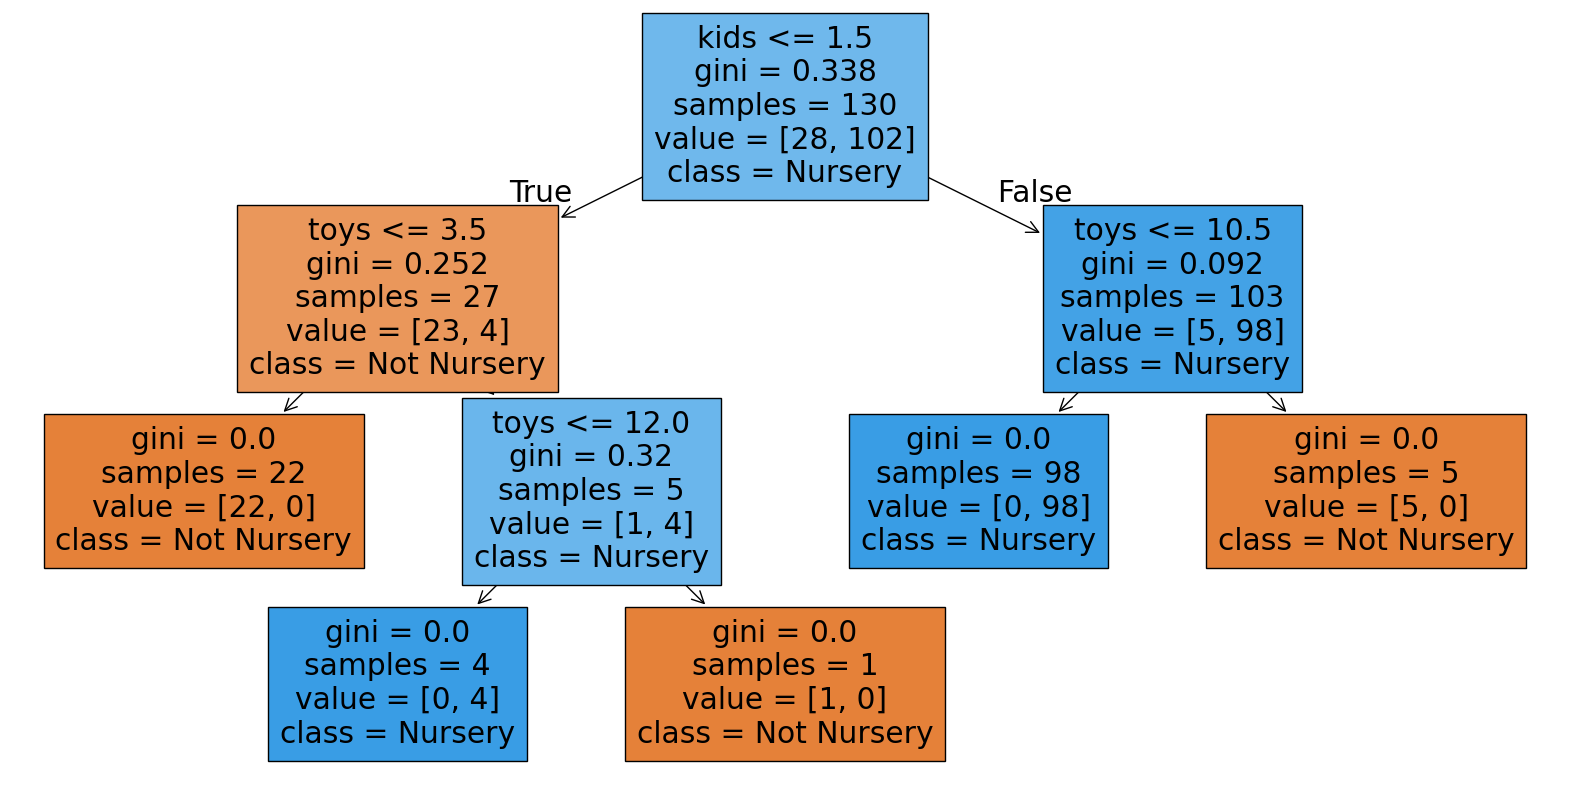

Model saved successfully!


In [70]:
import joblib
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming your data is in 'X' and 'y' (features and target)
# Step 1: Handle missing values
X = X.replace('N/A', np.nan)  # Replace 'N/A' with NaN if necessary
X = X.fillna(X.mean())  # Replace NaN values with the column mean

# Step 2: Encode categorical variables if needed
# Example: Label encoding for a categorical column
# X['categorical_column'] = label_encoder.fit_transform(X['categorical_column'])

# Step 3: Convert all features to numeric
X = X.apply(pd.to_numeric, errors='coerce')

# Step 4: Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Step 5: Train the Decision Tree classifier
clf = DecisionTreeClassifier(random_state=42, max_depth=5, criterion='gini')
clf.fit(X_train, y_train)

# Step 6: Predict on the test set
y_pred = clf.predict(X_test)

# Step 7: Evaluate the classifier
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Print accuracy score
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

# Step 8: Visualize the Decision Tree
plt.figure(figsize=(20, 10))

# Convert class_names to strings
class_names = ['Not Nursery', 'Nursery']  # Corresponding labels for 0 and 1

# Plot the tree
plot_tree(clf, feature_names=X.columns, class_names=class_names, filled=True)

# Show the plot
plt.show()

# Step 9: Save the trained model to a file using joblib
joblib.dump(clf, 'decision_tree_model.pkl')

print("Model saved successfully!")


# TESTING

Steps to Run Your Model:

    Prepare the Test Data: Ensure that you have a folder with test images and a format similar to your training dataset. The images should be processed using the same object detection model (e.g., Detectron2 or another pre-trained model).

    Pre-process the Images: This includes detecting objects from images, applying quantifiers to filter out excessive objects, and computing facet scores.

    Run the Trained Model (Decision Tree): Once the test images are pre-processed, you can run the classifier (Decision Tree) to predict whether each image belongs to "Nursery" or "Not Nursery".

    Evaluate the Performance: After running predictions on the test set, evaluate the model's performance based on accuracy, precision, recall, and F1-score.

In [42]:
import joblib

# Load the trained decision tree model (if saved)
clf = joblib.load("decision_tree_model.pkl")  # Adjust the path if needed


**Predicting all images in a test set**

In [77]:
import cv2
import random
from detectron2.utils.visualizer import Visualizer, ColorMode
import matplotlib.pyplot as plt
from detectron2.data import DatasetCatalog, MetadataCatalog

# Initialize the list to store detected objects for each image
detected_objects_per_image = []

# Get the training dataset
dataset_train = DatasetCatalog.get(cfg.DATASETS.TEST[0])
metadata = MetadataCatalog.get(cfg.DATASETS.TEST[0])

# Define the target size for resizing (adjust the dimensions as needed)
target_width = 640  
target_height = 480  

# Iterate over all images in the dataset
for idx, entry in enumerate(dataset_train):
    # Load the image
    img = cv2.imread(entry["file_name"])

    # Resize the image
    img_resized = cv2.resize(img, (target_width, target_height))  # Resize to the target dimensions
    print(f"Image {entry['file_name']} resized to {img_resized.shape[1]}x{img_resized.shape[0]}")

    # Run the predictor on the resized image
    outputs = predictor(img_resized)

    # Get the detected class names from the outputs
    instances = outputs["instances"]
    detected_class_indexes = instances.pred_classes
    prediction_boxes = instances.pred_boxes

    # Get the class names from the metadata
    class_catalog = metadata.thing_classes

    # Create a list for the detected class names
    class_name_list = []
    for idx, coordinates in enumerate(prediction_boxes):
        class_index = detected_class_indexes[idx]
        class_name = class_catalog[class_index]
        class_name_list.append(class_name)

    # Append the results to the list
    detected_objects_per_image.append({
        'image': entry["file_name"],  # Use the file name as the image identifier
        'detected_objects': class_name_list  # Detected objects
    })

# Print the results
print("\nDetected objects in all images:")
for result in detected_objects_per_image:
    print(result)


WARNING [12/16 12:15:27 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/16 12:15:27 d2.data.datasets.coco]: Loaded 25 images in COCO format from nursery_room_data/test/_annotations.coco.json
Image nursery_room_data/test/food_972fae87-e200-45aa-81f2-7847142e4c3b_jpeg_jpg.rf.9709af3315f7aca5f1434696704c5489.jpg resized to 640x480
Image nursery_room_data/test/G6949__448__1-00__1-03__fix_anonymized__frame-0_png_jpg.rf.64a105f635d4a178265b822d0ee899cd.jpg resized to 640x480
Image nursery_room_data/test/G6944__441__0-08__0-16__fix_anonymized__frame-9_png_jpg.rf.43e27500bc3a10da85491ca95d20b105.jpg resized to 640x480
Image nursery_room_data/test/G9104__267__0-55__1-06__fix_anonymized__frame-246_png_jpg.rf.fdce3b8c14909d8946a9fc2981e87f93.jpg resized to 640x480
Image nursery_room_data/test/caregiver4_jpg.rf.4a2d6c7b45a323dedb2af136e2534b1f.jpg resized to 640x480
Image nursery_room_data/test/G6965__44__0-09__0-16__fix_anonymi

In [81]:
print(f"Number of images in the dataset: {len(dataset_train)}")

Number of images in the dataset: 25


Image nursery_room_data/test/G6943__441__0-08__0-16__fix_anonymized__frame-87_png_jpg.rf.f71ed709254577a73bd7cf272d9951fd.jpg resized to 640x480
Image nursery_room_data/test/G6942__441__0-08__0-16__fix_anonymized__frame-84_png_jpg.rf.352623ed1978edb5cd790ccc4e8d3dd8.jpg has 22 predictions

Detected objects after counting: {'kid': 11, 'toy': 10, 'food': 0, 'caregiver': 1}
Detected objects: {'kid': 11, 'toy': 10, 'food': 0, 'caregiver': 1}
Facet scores: {'kid': {'plausibility': 0.9, 'typicality': 0.95, 'remarkability': 0.95, 'salience': 0.85}, 'toy': {'plausibility': 0.85, 'typicality': 0.9, 'remarkability': 0.7, 'salience': 0.8}, 'food': {'plausibility': 0.6, 'typicality': 0.5, 'remarkability': 0.6, 'salience': 0.65}, 'caregiver': {'plausibility': 0.75, 'typicality': 0.8, 'remarkability': 0.85, 'salience': 0.75}}
Aavg score: 0.861
Predicted class: 1
Number of results for the image: 1

Final Results:
                                               image  \
0  nursery_room_data/test/G6942_

/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


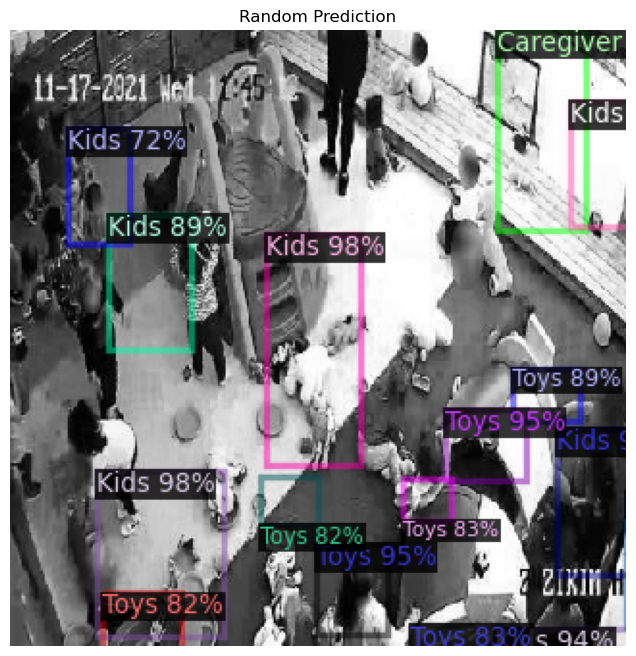

In [87]:
import cv2
import joblib
import matplotlib.pyplot as plt

# Load your trained decision tree model
clf = joblib.load('decision_tree_model.pkl')

# Initialize the results list to store the output for the image
results = []

# Specify the image you want to test
test_image_path = "nursery_room_data/test/G6942__441__0-08__0-16__fix_anonymized__frame-84_png_jpg.rf.352623ed1978edb5cd790ccc4e8d3dd8.jpg"
# Define the target size for resizing (adjust the dimensions as needed)
target_width = 640  
target_height = 480  

# Load the image
img = cv2.imread(test_image_path)
# Resize the image
img_resized = cv2.resize(img, (target_width, target_height))  # Resize to the target dimensions
print(f"Image {entry['file_name']} resized to {img_resized.shape[1]}x{img_resized.shape[0]}")

# Run the predictor on the image
outputs = predictor(img_resized)  # Use your predictor here

instances = outputs["instances"]
detected_class_indexes = instances.pred_classes

# Print the number of detected objects (predictions) for the image
print(f"Image {test_image_path} has {len(detected_class_indexes)} predictions")

# Continue with your feature extraction and prediction code
class_name_list = [class_catalog[i] for i in detected_class_indexes.tolist()]

# Apply quantifiers and facet scoring
result = apply_quantifiers_and_compute_facet_scores(class_name_list)

if result is not None:
    detected_objects, facet_scores, Aavg = result
    print(f"Detected objects: {detected_objects}")
    print(f"Facet scores: {facet_scores}")
    print(f"Aavg score: {round(Aavg, 3)}")

    # Prepare the feature vector for the decision tree
    feature_vector = [
        detected_objects['kid'],
        detected_objects['toy'],
        detected_objects['caregiver'],
        detected_objects['food'],
        Aavg
    ]

    # Predict with the decision tree
    predicted_class = clf.predict([feature_vector])[0]  # Make the prediction here
    print(f"Predicted class: {predicted_class}")

    # Store the result
    results.append({
        'image': test_image_path,  
        'detected_objects': detected_objects,
        'facet_scores': facet_scores,
        'Aavg': round(Aavg, 3),
        'predicted_class': predicted_class
    })
else:
    print(f"Excluding image {test_image_path} due to exceeding quantifier limits.")
    results.append({
        'image': test_image_path,
        'detected_objects': None,
        'facet_scores': None,
        'Aavg': None,
        'predicted_class': 'Excluded'
    })

# After processing, print the results for this single image
print(f"Number of results for the image: {len(results)}")

# Convert results to DataFrame and save to CSV
df_results = pd.DataFrame(results)

# Save the results to a CSV file
df_results.to_csv('single_image_test_prediction.csv', index=False)

# Display the DataFrame with the results
print("\nFinal Results:")
print(df_results)

# Convert the image from BGR to RGB (OpenCV uses BGR, but Matplotlib uses RGB)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Visualize the predictions
visualizer = Visualizer(
    img[:, :, ::-1],
    metadata=metadata, 
    scale=0.8, 
    instance_mode=ColorMode.IMAGE_BW
)
out = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))

# Convert the result to a format suitable for matplotlib
result_image = out.get_image()[:, :, ::-1]

# Display the result inline using matplotlib
plt.figure(figsize=(12, 8))
plt.imshow(result_image)
plt.axis("off")
plt.title("Random Prediction")
plt.show()


In [92]:
import cv2
import joblib
import pandas as pd

# Load your trained decision tree model
clf = joblib.load('decision_tree_model.pkl')

# Initialize the results list to store the output for each image
results = []

# Iterate through the dataset (test set in this case)
for idx, entry in enumerate(dataset_train):
    # Load the image
    img = cv2.imread(entry["file_name"])
    
    # Run the predictor on the resized image
    outputs = predictor(img)  # Use your predictor here
    
    instances = outputs["instances"]
    detected_class_indexes = instances.pred_classes
    
    # Print the number of detected objects (predictions) for each image
    print(f"Image {entry['file_name']} has {len(detected_class_indexes)} predictions")

    # Continue with your feature extraction and prediction code
    class_name_list = [class_catalog[i] for i in detected_class_indexes.tolist()]
    
    # Apply quantifiers and facet scoring
    result = apply_quantifiers_and_compute_facet_scores(class_name_list)

    if result is not None:
        detected_objects, facet_scores, Aavg = result
        print(f"Detected objects: {detected_objects}")
        print(f"Facet scores: {facet_scores}")
        print(f"Aavg score: {round(Aavg, 3)}")
        
        # Prepare the feature vector for the decision tree
        feature_vector = [
            detected_objects['kid'],
            detected_objects['toy'],
            detected_objects['caregiver'],
            detected_objects['food'],
            Aavg
        ]
        
        # Predict with the decision tree
        predicted_class_numeric = clf.predict([feature_vector])[0]  # Make the prediction here
        # Map the numeric prediction to class labels
        predicted_class = 'Nursery' if predicted_class_numeric == 1 else 'Not Nursery'
        print(f"Predicted class: {predicted_class}")
        
        # Store only necessary information for the CSV
        results.append({
            'image': entry["file_name"],  
            'detected_objects_count': {
                'kid': detected_objects['kid'],
                'toy': detected_objects['toy'],
                'caregiver': detected_objects['caregiver'],
                'food': detected_objects['food']
            },
            'facet_scores': facet_scores,
            'Aavg': round(Aavg, 3),
            'predicted_class': predicted_class
        })
    else:
        print(f"Excluding image {entry['file_name']} due to exceeding quantifier limits.")
        results.append({
            'image': entry["file_name"],
            'detected_objects_count': None,
            'facet_scores': None,
            'Aavg': None,
            'predicted_class': 'Excluded'
        })

# Convert the results into a pandas DataFrame, only including the necessary columns
df_results = pd.DataFrame(results)

# Write the results to a CSV file, including only image, detected objects count, facet scores, Aavg, and predicted class
df_results.to_csv('test_predictions.csv', columns=['image', 'detected_objects_count', 'facet_scores', 'Aavg', 'predicted_class'], index=False)

# Display the DataFrame with the results
print("\nFinal Results:")
print(df_results)


Image nursery_room_data/test/food_972fae87-e200-45aa-81f2-7847142e4c3b_jpeg_jpg.rf.9709af3315f7aca5f1434696704c5489.jpg has 12 predictions

Detected objects after counting: {'kid': 6, 'toy': 0, 'food': 6, 'caregiver': 0}
Excluding image: Too many foods detected (exceeds limit).
Excluding image nursery_room_data/test/food_972fae87-e200-45aa-81f2-7847142e4c3b_jpeg_jpg.rf.9709af3315f7aca5f1434696704c5489.jpg due to exceeding quantifier limits.
Image nursery_room_data/test/G6949__448__1-00__1-03__fix_anonymized__frame-0_png_jpg.rf.64a105f635d4a178265b822d0ee899cd.jpg has 5 predictions

Detected objects after counting: {'kid': 4, 'toy': 0, 'food': 0, 'caregiver': 1}
Detected objects: {'kid': 4, 'toy': 0, 'food': 0, 'caregiver': 1}
Facet scores: {'kid': {'plausibility': 0.9, 'typicality': 0.95, 'remarkability': 0.95, 'salience': 0.85}, 'toy': {'plausibility': 0.85, 'typicality': 0.9, 'remarkability': 0.7, 'salience': 0.8}, 'food': {'plausibility': 0.6, 'typicality': 0.5, 'remarkability': 0.6

/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


Image nursery_room_data/test/caregiver4_jpg.rf.4a2d6c7b45a323dedb2af136e2534b1f.jpg has 12 predictions

Detected objects after counting: {'kid': 11, 'toy': 0, 'food': 0, 'caregiver': 1}
Detected objects: {'kid': 11, 'toy': 0, 'food': 0, 'caregiver': 1}
Facet scores: {'kid': {'plausibility': 0.9, 'typicality': 0.95, 'remarkability': 0.95, 'salience': 0.85}, 'toy': {'plausibility': 0.85, 'typicality': 0.9, 'remarkability': 0.7, 'salience': 0.8}, 'food': {'plausibility': 0.6, 'typicality': 0.5, 'remarkability': 0.6, 'salience': 0.65}, 'caregiver': {'plausibility': 0.75, 'typicality': 0.8, 'remarkability': 0.85, 'salience': 0.75}}
Aavg score: 0.902
Predicted class: Nursery
Image nursery_room_data/test/G6965__44__0-09__0-16__fix_anonymized__frame-120_png_jpg.rf.2e6e08d0419e19b0c06fc8b3691e8f3f.jpg has 13 predictions

Detected objects after counting: {'kid': 2, 'toy': 10, 'food': 0, 'caregiver': 1}
Detected objects: {'kid': 2, 'toy': 10, 'food': 0, 'caregiver': 1}
Facet scores: {'kid': {'pla

/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


Image nursery_room_data/test/food_d6c8d4e7-2efe-4257-aa2e-f3751d2748f5_jpeg_jpg.rf.b7217378702791d5a74a022bf96ebc2b.jpg has 13 predictions

Detected objects after counting: {'kid': 3, 'toy': 0, 'food': 9, 'caregiver': 1}
Excluding image: Too many foods detected (exceeds limit).
Excluding image nursery_room_data/test/food_d6c8d4e7-2efe-4257-aa2e-f3751d2748f5_jpeg_jpg.rf.b7217378702791d5a74a022bf96ebc2b.jpg due to exceeding quantifier limits.
Image nursery_room_data/test/kids_26_jpg.rf.082d5bb8815844721c6e16e8686f99e6.jpg has 16 predictions

Detected objects after counting: {'kid': 14, 'toy': 1, 'food': 0, 'caregiver': 1}
Detected objects: {'kid': 14, 'toy': 1, 'food': 0, 'caregiver': 1}
Facet scores: {'kid': {'plausibility': 0.9, 'typicality': 0.95, 'remarkability': 0.95, 'salience': 0.85}, 'toy': {'plausibility': 0.85, 'typicality': 0.9, 'remarkability': 0.7, 'salience': 0.8}, 'food': {'plausibility': 0.6, 'typicality': 0.5, 'remarkability': 0.6, 'salience': 0.65}, 'caregiver': {'plaus

/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


Image nursery_room_data/test/kids_195_jpg.rf.9545aa750e6058622dfbbdebb4e349cc.jpg has 9 predictions

Detected objects after counting: {'kid': 6, 'toy': 1, 'food': 0, 'caregiver': 2}
Detected objects: {'kid': 6, 'toy': 1, 'food': 0, 'caregiver': 2}
Facet scores: {'kid': {'plausibility': 0.9, 'typicality': 0.95, 'remarkability': 0.95, 'salience': 0.85}, 'toy': {'plausibility': 0.85, 'typicality': 0.9, 'remarkability': 0.7, 'salience': 0.8}, 'food': {'plausibility': 0.6, 'typicality': 0.5, 'remarkability': 0.6, 'salience': 0.65}, 'caregiver': {'plausibility': 0.75, 'typicality': 0.8, 'remarkability': 0.85, 'salience': 0.75}}
Aavg score: 0.874
Predicted class: Nursery
Image nursery_room_data/test/G6939__441__0-08__0-16__fix_anonymized__frame-75_png_jpg.rf.96e4c4a41bc1e7420635e2356d700b41.jpg has 20 predictions

Detected objects after counting: {'kid': 11, 'toy': 8, 'food': 0, 'caregiver': 1}
Detected objects: {'kid': 11, 'toy': 8, 'food': 0, 'caregiver': 1}
Facet scores: {'kid': {'plausibi

/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


Image nursery_room_data/test/caregiver181_jpg.rf.492b90318842bd07c14c108fe28debe6.jpg has 11 predictions

Detected objects after counting: {'kid': 9, 'toy': 0, 'food': 0, 'caregiver': 2}
Detected objects: {'kid': 9, 'toy': 0, 'food': 0, 'caregiver': 2}
Facet scores: {'kid': {'plausibility': 0.9, 'typicality': 0.95, 'remarkability': 0.95, 'salience': 0.85}, 'toy': {'plausibility': 0.85, 'typicality': 0.9, 'remarkability': 0.7, 'salience': 0.8}, 'food': {'plausibility': 0.6, 'typicality': 0.5, 'remarkability': 0.6, 'salience': 0.65}, 'caregiver': {'plausibility': 0.75, 'typicality': 0.8, 'remarkability': 0.85, 'salience': 0.75}}
Aavg score: 0.89
Predicted class: Nursery
Image nursery_room_data/test/caregiver166_jpg.rf.f96c2e560696ab4859e32c6ef2f58141.jpg has 11 predictions

Detected objects after counting: {'kid': 9, 'toy': 0, 'food': 2, 'caregiver': 0}
Detected objects: {'kid': 9, 'toy': 0, 'food': 2, 'caregiver': 0}
Facet scores: {'kid': {'plausibility': 0.9, 'typicality': 0.95, 'remar

/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


Image nursery_room_data/test/IMG-20240123-WA0007_jpg.rf.c1cb1a5225dbd8696af2d71f80ddf5af.jpg has 8 predictions

Detected objects after counting: {'kid': 0, 'toy': 7, 'food': 1, 'caregiver': 0}
Detected objects: {'kid': 0, 'toy': 7, 'food': 1, 'caregiver': 0}
Facet scores: {'kid': {'plausibility': 0.9, 'typicality': 0.95, 'remarkability': 0.95, 'salience': 0.85}, 'toy': {'plausibility': 0.85, 'typicality': 0.9, 'remarkability': 0.7, 'salience': 0.8}, 'food': {'plausibility': 0.6, 'typicality': 0.5, 'remarkability': 0.6, 'salience': 0.65}, 'caregiver': {'plausibility': 0.75, 'typicality': 0.8, 'remarkability': 0.85, 'salience': 0.75}}
Aavg score: 0.784
Predicted class: Nursery
Image nursery_room_data/test/G6958__44__0-09__0-16__fix_anonymized__frame-102_png_jpg.rf.4bec31d0ec759b1c9af7739fc06ce6b1.jpg has 14 predictions

Detected objects after counting: {'kid': 3, 'toy': 10, 'food': 0, 'caregiver': 1}
Detected objects: {'kid': 3, 'toy': 10, 'food': 0, 'caregiver': 1}
Facet scores: {'kid':

/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


Image nursery_room_data/test/caregiver66_jpg.rf.39fa74e8e411549366e4b3f7628b784a.jpg has 6 predictions

Detected objects after counting: {'kid': 4, 'toy': 0, 'food': 0, 'caregiver': 2}
Detected objects: {'kid': 4, 'toy': 0, 'food': 0, 'caregiver': 2}
Facet scores: {'kid': {'plausibility': 0.9, 'typicality': 0.95, 'remarkability': 0.95, 'salience': 0.85}, 'toy': {'plausibility': 0.85, 'typicality': 0.9, 'remarkability': 0.7, 'salience': 0.8}, 'food': {'plausibility': 0.6, 'typicality': 0.5, 'remarkability': 0.6, 'salience': 0.65}, 'caregiver': {'plausibility': 0.75, 'typicality': 0.8, 'remarkability': 0.85, 'salience': 0.75}}
Aavg score: 0.871
Predicted class: Nursery
Image nursery_room_data/test/food_62_jpg.rf.999b0e139cd302069ab4a8e7d3739af6.jpg has 12 predictions

Detected objects after counting: {'kid': 6, 'toy': 1, 'food': 4, 'caregiver': 1}
Detected objects: {'kid': 6, 'toy': 1, 'food': 4, 'caregiver': 1}
Facet scores: {'kid': {'plausibility': 0.9, 'typicality': 0.95, 'remarkabili

/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


# CLIP model on test images folder


In [95]:
!pip install git+https://github.com/openai/CLIP.git
!pip install torch torchvision


  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-7xwrsv6i
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-7xwrsv6i
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369489 sha256=d5f39fa63ca9ee8c3487678c4e9546cd9e284c8e06f641852b6e25aa016daa33
  Stored in directory: /tmp/pip-ephem-wheel-cache-173rxonh/wheels/3f/7c/a4/9b490845988bf7a4db33674d52f709f088f64392063872eb9a
Successfully built clip


In [11]:
import torch
import clip
from PIL import Image
import pandas as pd
import os
import matplotlib.pyplot as plt

# Load the CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device)

# Define descriptive class names for CLIP
class_names = [
    "A photo of a childcare nursery with children and caregivers",  # Childcare nursery
    "A photo of a general room, not a nursery"  # General room (Not Nursery)
]

# Define a mapping for simplified class labels
class_mapping = {
    "A photo of a childcare nursery with children and caregivers": "Nursery",
    "A photo of a general room, not a nursery": "Not Nursery"
}

# Initialize results list for CLIP predictions
clip_results = []

# Path to your test images folder
test_folder = "nursery_room_data/test/"  # Replace with your actual test folder path

# Iterate through the test images folder
for filename in os.listdir(test_folder):
    if filename.endswith(('.jpg', '.png')):  # Process only .jpg or .png images
        img_path = os.path.join(test_folder, filename)
        
        # Load and preprocess the image
        image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)

        # Encode the image and class names with the CLIP model
        image_features = model.encode_image(image)
        text_inputs = torch.cat([clip.tokenize(f"{class_name}") for class_name in class_names]).to(device)
        text_features = model.encode_text(text_inputs)

        # Calculate similarity between image and each class text
        similarity = (image_features @ text_features.T).squeeze(0)
        
        # Print similarity scores for debugging
        print(f"Similarity scores for {img_path}: {similarity}")

        # Get the predicted class based on the highest similarity
        predicted_class_index = similarity.argmax().item()
        descriptive_class = class_names[predicted_class_index]
        simplified_class = class_mapping[descriptive_class]  # Map to simplified class names
        
        # Store the results
        clip_results.append({
            'image': img_path,
            'clip_predicted_class': simplified_class  # Store the simplified class name
        })

# Convert the CLIP results to a DataFrame
df_clip_results = pd.DataFrame(clip_results)

# Display the results for debugging
print("\nCLIP Model Results:")
print(df_clip_results)

# Save the results to a CSV file
df_clip_results.to_csv("clip_predictions.csv", index=False)


Similarity scores for nursery_room_data/test/caregiver181_jpg.rf.492b90318842bd07c14c108fe28debe6.jpg: tensor([31.1875, 28.4531], device='cuda:0', dtype=torch.float16,
       grad_fn=<SqueezeBackward1>)
Similarity scores for nursery_room_data/test/caregiver4_jpg.rf.4a2d6c7b45a323dedb2af136e2534b1f.jpg: tensor([25.3906, 23.7344], device='cuda:0', dtype=torch.float16,
       grad_fn=<SqueezeBackward1>)
Similarity scores for nursery_room_data/test/caregiver166_jpg.rf.f96c2e560696ab4859e32c6ef2f58141.jpg: tensor([29.2656, 23.3594], device='cuda:0', dtype=torch.float16,
       grad_fn=<SqueezeBackward1>)
Similarity scores for nursery_room_data/test/caregiver146_jpg.rf.f2e9eb5daff1a6b83aea1f21852c2621.jpg: tensor([31.9062, 28.0312], device='cuda:0', dtype=torch.float16,
       grad_fn=<SqueezeBackward1>)
Similarity scores for nursery_room_data/test/food_5ff07b8b-804f-4e38-9f8d-e148a13e4185_jpeg_jpg.rf.cd502f83ad6e2a31faba04e107ef23db.jpg: tensor([24.4531, 22.7969], device='cuda:0', dtype=tor

In [12]:
# Explicitly verify mapping for debugging
for result in clip_results:
    print(f"Image: {result['image']}, Predicted Class: {result['clip_predicted_class']}")


Image: nursery_room_data/test/caregiver181_jpg.rf.492b90318842bd07c14c108fe28debe6.jpg, Predicted Class: Nursery
Image: nursery_room_data/test/caregiver4_jpg.rf.4a2d6c7b45a323dedb2af136e2534b1f.jpg, Predicted Class: Nursery
Image: nursery_room_data/test/caregiver166_jpg.rf.f96c2e560696ab4859e32c6ef2f58141.jpg, Predicted Class: Nursery
Image: nursery_room_data/test/caregiver146_jpg.rf.f2e9eb5daff1a6b83aea1f21852c2621.jpg, Predicted Class: Nursery
Image: nursery_room_data/test/food_5ff07b8b-804f-4e38-9f8d-e148a13e4185_jpeg_jpg.rf.cd502f83ad6e2a31faba04e107ef23db.jpg, Predicted Class: Nursery
Image: nursery_room_data/test/caregiver66_jpg.rf.39fa74e8e411549366e4b3f7628b784a.jpg, Predicted Class: Nursery
Image: nursery_room_data/test/food_171a9eee-3276-4ab9-b093-f6c486c6fda1_jpeg_jpg.rf.ee5c879b941843653ff3fa5bed6ce464.jpg, Predicted Class: Nursery
Image: nursery_room_data/test/food_d6c8d4e7-2efe-4257-aa2e-f3751d2748f5_jpeg_jpg.rf.b7217378702791d5a74a022bf96ebc2b.jpg, Predicted Class: Nurse

In [10]:
print(df_clip_results.head())


                                               image clip_predicted_class
0  nursery_room_data/test/caregiver181_jpg.rf.492...              Nursery
1  nursery_room_data/test/caregiver4_jpg.rf.4a2d6...              Nursery
2  nursery_room_data/test/caregiver166_jpg.rf.f96...              Nursery
3  nursery_room_data/test/caregiver146_jpg.rf.f2e...              Nursery
4  nursery_room_data/test/food_5ff07b8b-804f-4e38...              Nursery


**Compare CLIP Predictions with Decision Tree Predictions**
Now that we have the predictions from both the CLIP model and our Decision Tree, we can compare them. Assuming that the Decision Tree predictions are already saved in test_predictions.csv, we can merge the two results into one DataFrame for comparison.

In [5]:
# Load the Decision Tree predictions CSV
df_dt_results = pd.read_csv('test_predictions.csv')

# Merge the two DataFrames based on the image path
df_comparison = pd.merge(df_dt_results, df_clip_results, on='image')

# Display the comparison results
print("\nComparison between Decision Tree and CLIP Predictions:")
print(df_comparison)

# Save the comparison results to a CSV file
df_comparison.to_csv('comparison_predictions.csv', index=False)



Comparison between Decision Tree and CLIP Predictions:
                                                image  \
0   nursery_room_data/test/food_972fae87-e200-45aa...   
1   nursery_room_data/test/G6949__448__1-00__1-03_...   
2   nursery_room_data/test/G6944__441__0-08__0-16_...   
3   nursery_room_data/test/G9104__267__0-55__1-06_...   
4   nursery_room_data/test/caregiver4_jpg.rf.4a2d6...   
5   nursery_room_data/test/G6965__44__0-09__0-16__...   
6   nursery_room_data/test/food_5ff07b8b-804f-4e38...   
7   nursery_room_data/test/G6942__441__0-08__0-16_...   
8   nursery_room_data/test/food_d6c8d4e7-2efe-4257...   
9   nursery_room_data/test/kids_26_jpg.rf.082d5bb8...   
10  nursery_room_data/test/G9149__267__0-55__1-06_...   
11  nursery_room_data/test/kids_195_jpg.rf.9545aa7...   
12  nursery_room_data/test/G6939__441__0-08__0-16_...   
13  nursery_room_data/test/G6964__44__0-09__0-16__...   
14  nursery_room_data/test/G8023__51__0-12__0-14__...   
15  nursery_room_data/test/careg

**Metrics to compare performance**

In [2]:
##LOAD and MERGE
import pandas as pd

# Load the CSVs
df_dt_results = pd.read_csv('test_predictions.csv')  # Decision Tree predictions
df_clip_results = pd.read_csv('clip_predictions.csv')  # CLIP predictions

# Merge the two DataFrames based on the `image` column
df_comparison = pd.merge(df_dt_results[['image', 'predicted_class']], 
                         df_clip_results[['image', 'clip_predicted_class']], 
                         on='image', 
                         how='inner')



# Visualize the Comparison

**Bar Chart: Class Distribution**

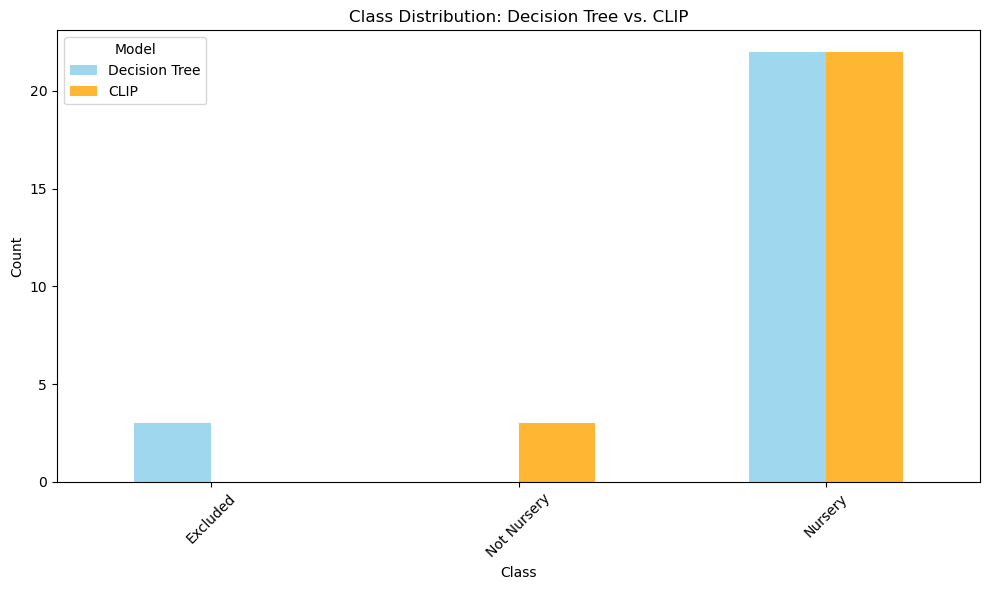

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

# Prepare data for plotting
class_distribution = pd.DataFrame({
    'Decision Tree': df_comparison['predicted_class'].value_counts(),
    'CLIP': df_comparison['clip_predicted_class'].value_counts()
})

# Plot a grouped bar chart
class_distribution.plot(kind='bar', figsize=(10, 6), color=['skyblue', 'orange'], alpha=0.8)

# Customize the plot
plt.title("Class Distribution: Decision Tree vs. CLIP")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Model")
plt.tight_layout()
# Save the plot as an image
plt.savefig("class_distribution_comparison_bar_chart.png", dpi=300)

plt.show()


**Side-by-Side Comparison of Predictions**

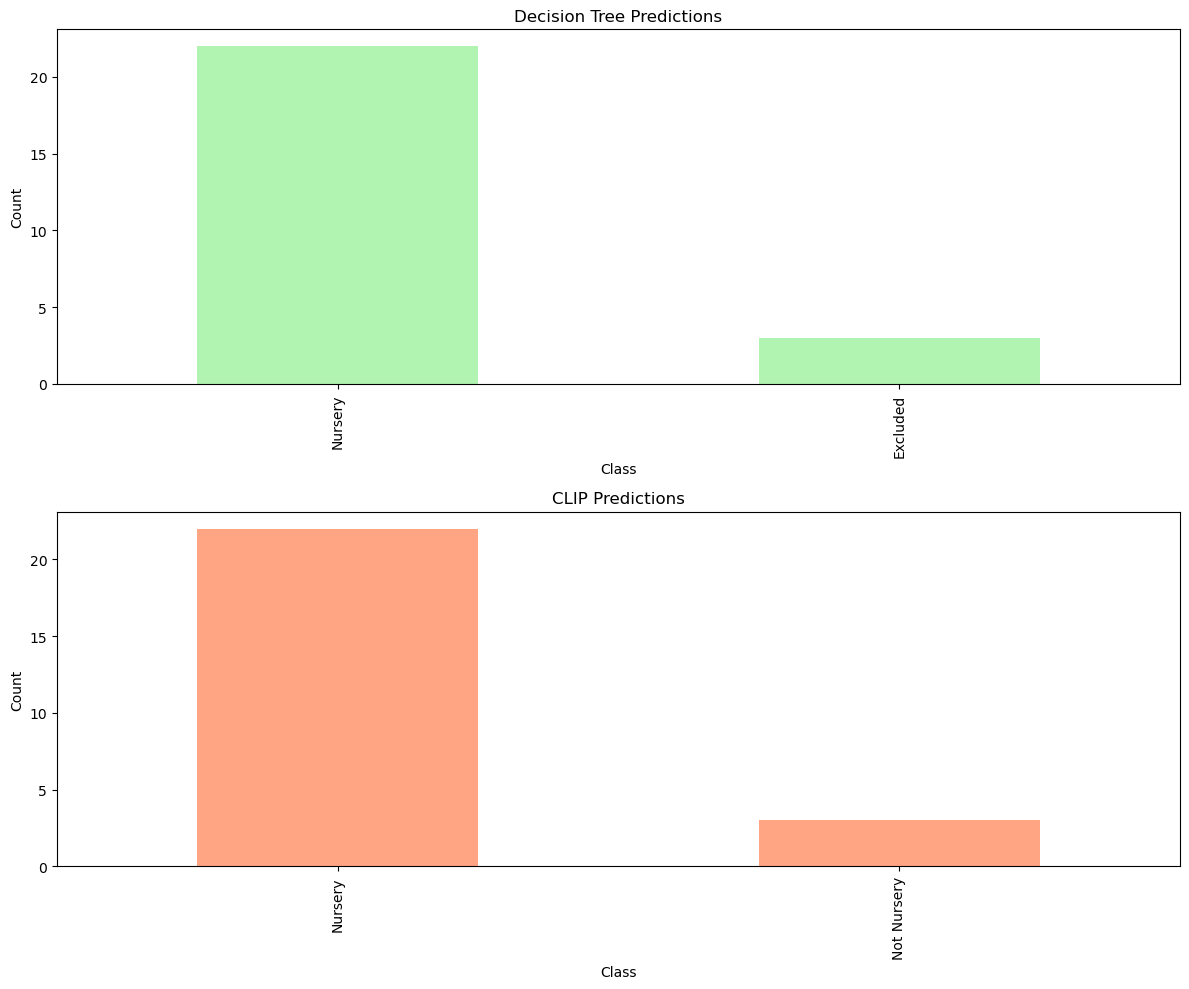

In [8]:
# Display side-by-side bar charts for the two predictions
df_comparison['image_index'] = df_comparison.index

fig, axes = plt.subplots(nrows=2, figsize=(12, 10))

# Plot for Decision Tree predictions
df_comparison['predicted_class'].value_counts().plot(kind='bar', ax=axes[0], color='lightgreen', title="Decision Tree Predictions", alpha=0.7)
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')

# Plot for CLIP predictions
df_comparison['clip_predicted_class'].value_counts().plot(kind='bar', ax=axes[1], color='coral', title="CLIP Predictions", alpha=0.7)
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()


**Compare the Accuracy**

Explanation:

    ['Nursery'] * len(df_comparison): This creates a list where each element is "Nursery," matching the number of images in your test set.
    df_comparison['predicted_class']: This contains the predictions from the Decision Tree model.
    df_comparison['clip_predicted_class']: This contains the predictions from the CLIP model.
    We then use accuracy_score to calculate how many of the predicted labels match the true label ("Nursery").

This will give you two accuracy values:

    Decision Tree accuracy: How well the Decision Tree performed.
    CLIP accuracy: How well the CLIP model performed.

In [10]:
from sklearn.metrics import accuracy_score

# True label is always "Nursery" for all images.
# We can compare predicted labels to "Nursery" (the true label for all samples)

# Calculate accuracy for Decision Tree
dt_accuracy = accuracy_score(['Nursery'] * len(df_comparison), df_comparison['predicted_class'])

# Calculate accuracy for CLIP
clip_accuracy = accuracy_score(['Nursery'] * len(df_comparison), df_comparison['clip_predicted_class'])

# Print the results
print(f"Decision Tree accuracy: {dt_accuracy:.2f}")
print(f"CLIP accuracy: {clip_accuracy:.2f}")


Decision Tree accuracy: 0.88
CLIP accuracy: 0.88
